In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras import optimizers
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,Conv2D,MaxPooling2D,Activation,Flatten,BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from skimage import io,color
from scipy import misc
import matplotlib.pyplot as plt
import os.path
import numpy as np
import pandas as pd
from os import listdir
import pickle
import _pickle as cPickle

%matplotlib inline

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [14]:
checkpointer = ModelCheckpoint(
    filepath=os.path.join('Checkpoints', 'checkpoints', 'inception.{epoch:03d}-{val_loss:.2f}.hdf5'),
    monitor='val_acc',
    verbose=1,
    save_best_only=True)

# Helper: Stop when we stop learning.
early_stopper = EarlyStopping(patience=5)

def get_generators():
    train_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        'CNN_Train',
        target_size=(64,64),
#         target_size=(299,299),
        batch_size=32,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
       'CNN_Test',
        target_size=(64,64),
#         target_size=(299,299),
        batch_size=32,
        class_mode='categorical')

    return train_generator, validation_generator

def get_model(weights='imagenet'):
    # create the base pre-trained model
    base_model = InceptionV3(weights=weights, include_top=False)
    # add a global spatial average pooling layer
    x = base_model.output
    predictions = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
#     x = Dense(1024, activation='relu')(x)
#     # and a logistic layer
#     x = Dropout(0.5)(x)
#     predictions = Dense(9, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def get_simple_model():
    model=Sequential()
    model.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D())
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(MaxPooling2D())
#    model.add(Dropout(0.3))
    model.add(Conv2D(32,(3,3),activation='relu'))
#     model.add(MaxPooling2D())
#     model.add(Dropout(0.3))
    model.add(Conv2D(32,(3,3),activation='relu'))
#     model.add(Dropout(0.3))
    model.add(MaxPooling2D())
    model.add(Conv2D(64,(3,3),activation='relu'))
#        model.add(Dropout(0.3))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(9,activation='softmax'))
    
#     sgd = optimizers.SGD(lr=0.001, momentum=0.9)
    adam=optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['categorical_accuracy'])
    print(model.summary())
    return model

def freeze_all_but_top(model):
    for layer in model.layers[:-2]:
        layer.trainable = False
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
    return model

def freeze_all_but_mid_and_top(model):
    for layer in model.layers[:172]:
        layer.trainable = False
    for layer in model.layers[172:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(
        optimizer=optimizers.SGD(lr=0.001, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy'])

    return model

def train_model(model, nb_epoch, generators, callbacks=[]):
    train_generator, validation_generator = generators
    model.fit_generator(
        train_generator,
        steps_per_epoch=120,
        validation_data=validation_generator,
        validation_steps=10,
        epochs=nb_epoch,
        callbacks=callbacks,
        shuffle=True)
    return model

def main(weights_file):
    model=get_simple_model()
    generators = get_generators()
    
    train_generator, validation_generator = generators
    model.fit_generator(
        train_generator,
        steps_per_epoch=120,
        validation_data=validation_generator,
        validation_steps=45,
        epochs=20,
        shuffle=True)
    model.save('Model7.h5')

In [15]:
if __name__ == '__main__':
    weights_file = None
    main(weights_file)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 11, 64)        18496     
__________

In [3]:
from keras.models import load_model
model=load_model('3000_RNN.h5')

/home/kathan/.local/lib/python3.4/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


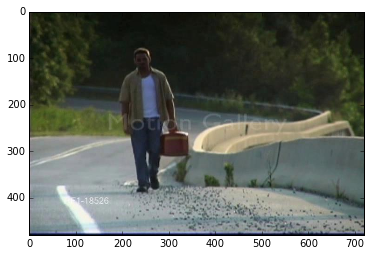

In [65]:
test_image=io.imread('Image9.jpg')
plt.imshow(test_image)
test_image=misc.imresize(test_image,(64,64,3))
test_image = test_image *(1./255)

[[5.26959728e-03 1.80535702e-04 1.01955404e-04 4.52490422e-05
  9.92692292e-01 5.15928084e-04 8.71902448e-04 3.92295260e-05
  2.83461064e-04]]


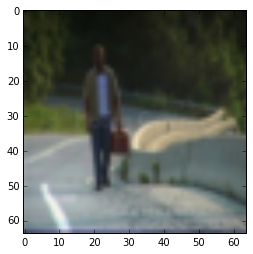

In [66]:
plt.imshow(test_image)
pred=model.predict(np.resize(test_image,(1,64,64,3)))
print(pred)

In [15]:
generators=get_generators()
train,val=generators

Found 5375 images belonging to 9 classes.
Found 1487 images belonging to 9 classes.


In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 128)       147584    
__________

In [19]:
pred=model.predict_generator(val)

In [17]:
print(val.classes)

[0 0 0 ... 8 8 8]


In [18]:
categories=["Golf","Kicking","Lifting","Riding","Running","SkateBoarding","Swing-Bench","Swing-SideAngle","Walking"]
count=0
for i in range(len(pred)):
    m=np.argmax(pred[i])
    if m != val.classes[i]:
        count=count+1
#         print(categories[val.classes[i]]+" "+categories[m])

# print("Acc:"+str(count/1487))

NameError: name 'pred' is not defined

In [19]:
model=get_model()

In [15]:
model.pop()
model.pop()
model.pop()

AttributeError: 'Model' object has no attribute 'pop'

In [27]:
categories=["Golf","Kicking","Lifting","Riding","Running","SkateBoarding","Swing-Bench","Swing-SideAngle","Walking"]
path="Train/"
rnn_train_x=[]
rnn_test_x=[]
rnn_train_y=[]
rnn_test_y=[]
for c in categories:
    items=listdir(path+c)
    for i in items:
        train_images=[]
        print(c+" "+i)
        images=listdir(path+c+'/'+i+'/')
        for imgs in range(len(images)):
#             print(imgs)
            img=io.imread(path+c+'/'+i+'/'+str(imgs)+'.jpg')
            img=misc.imresize(img,(64,64,3))
            img=img*(1./255)
            if len(train_images)==0:
                train_images.append(img)
            
            else:
                train_images.append(img)
            
        x_train=np.array(train_images)
        x_predict=model.predict(x_train) 
#         print(x_predict.shape)
        if x_predict.shape[0]<50:
            x_predict=np.vstack((x_predict,np.zeros((50-x_predict.shape[0],x_predict.shape[1]))))
        else:
            jump=int(x_predict.shape[0]/50)
            x_train_new=[]
            for i in range(0,x_predict.shape[0],jump)[:50]:
                if i==0:
                    x_train_new=(x_predict[i])
                else:
                    x_train_new=np.vstack((x_train_new,x_predict[i]))
            x_predict=np.array(x_train_new)
#         print(x_predict.shape)
        
        y_onehot=np.zeros([1,9])
        y_onehot[0,categories.index(c)]=1
        
        if len(rnn_train_x)==0:
            rnn_train_x.append(x_predict)
            rnn_train_y=y_onehot
        else:
            rnn_train_x.append(x_predict)
            rnn_train_y=np.vstack((rnn_train_y,y_onehot))

path1='Test/'
for c in categories:
    items=listdir(path1+c)
    for i in items:
        train_images=[]
        print(c+" "+i)
        images=listdir(path1+c+'/'+i+'/')
        for imgs in range(len(images)):
#             print(imgs)
            img=io.imread(path1+c+'/'+i+'/'+str(imgs)+'.jpg')
            img=misc.imresize(img,(64,64,3))
            img=img*(1./255)
            if len(train_images)==0:
                train_images.append(img)
            
            else:
                train_images.append(img)
            
        x_train=np.array(train_images)
        x_predict=model.predict(x_train) 
#         print(x_predict.shape)
        if x_predict.shape[0]<50:
            x_predict=np.vstack((x_predict,np.zeros((50-x_predict.shape[0],x_predict.shape[1]))))
        else:
            jump=int(x_predict.shape[0]/50)
            x_train_new=[]
            for i in range(0,x_predict.shape[0],jump)[:50]:
                if i==0:
                    x_train_new=(x_predict[i])
                else:
                    x_train_new=np.vstack((x_train_new,x_predict[i]))
            x_predict=np.array(x_train_new)
#         print(x_predict.shape)
        
        y_onehot=np.zeros([1,9])
        y_onehot[0,categories.index(c)]=1
        
        if len(rnn_test_x)==0:
            rnn_test_x.append(x_predict)
            rnn_test_y=y_onehot
        else:
            rnn_test_x.append(x_predict)
            rnn_test_y=np.vstack((rnn_test_y,y_onehot))
        
rnn_train_x=np.array(rnn_train_x)
rnn_test_x=np.array(rnn_test_x)
train_data=list(zip(rnn_train_x,rnn_train_y))
test_data=list(zip(rnn_test_x,rnn_test_y))

cPickle.dump(train_data,open('RNN_Train_Inc.p','wb'))
cPickle.dump(test_data,open('RNN_Test_Inc.p','wb'))

Golf 0


/home/kathan/.local/lib/python3.4/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


Golf 1
Golf 10
Golf 12
Golf 13
Golf 2
Golf 5
Golf 6
Golf 7
Golf 8
Golf 9
Kicking 0
Kicking 10
Kicking 11
Kicking 12
Kicking 15
Kicking 2
Kicking 3
Kicking 4
Kicking 6
Kicking 7
Kicking 8
Kicking 9
Lifting 0
Lifting 1
Lifting 3
Lifting 4
Riding 0
Riding 1
Riding 3
Riding 4
Riding 6
Riding 7
Riding 8
Riding 9
Running 0
Running 10
Running 2
Running 3
Running 4
Running 5
Running 6
Running 7
SkateBoarding 0
SkateBoarding 1
SkateBoarding 2
SkateBoarding 3
SkateBoarding 4
SkateBoarding 5
SkateBoarding 8
SkateBoarding 9
Swing-Bench 1
Swing-Bench 10
Swing-Bench 11
Swing-Bench 12
Swing-Bench 13
Swing-Bench 14
Swing-Bench 15
Swing-Bench 2
Swing-Bench 4
Swing-Bench 6
Swing-Bench 7
Swing-Bench 8
Swing-Bench 9
Swing-SideAngle 1
Swing-SideAngle 10
Swing-SideAngle 2
Swing-SideAngle 3
Swing-SideAngle 5
Swing-SideAngle 6
Swing-SideAngle 7
Swing-SideAngle 9
Walking 0
Walking 1
Walking 10
Walking 11
Walking 12
Walking 13
Walking 14
Walking 16
Walking 17
Walking 2
Walking 3
Walking 4
Walking 6
Walking 8
Wa

/home/kathan/.local/lib/python3.4/site-packages/ipykernel_launcher.py:60: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Golf 3
Golf 4
Kicking 1
Kicking 13
Kicking 14
Kicking 5
Lifting 2
Riding 2
Riding 5
Running 1
Running 8
Running 9
SkateBoarding 6
SkateBoarding 7
Swing-Bench 0
Swing-Bench 16
Swing-Bench 3
Swing-Bench 5
Swing-SideAngle 0
Swing-SideAngle 4
Swing-SideAngle 8
Walking 15
Walking 18
Walking 5
Walking 7


In [28]:
train_data=cPickle.load(open('RNN_Train_Inc.p','rb'))
test_data=cPickle.load(open('RNN_Test_Inc.p','rb'))

x_train,y_train=[train_data[i][0] for i in range(len(train_data))],[train_data[i][1] for i in range(len(train_data))]
x_test,y_test=[test_data[i][0] for i in range(len(test_data))],[test_data[i][1] for i in range(len(test_data))]

In [29]:
print(len(x_train))
print(len(x_test))
x_train=np.array(x_train)
x_test=np.array(x_test)
print(x_train.shape)
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
print(y_train.shape)

87
26
(87, 50, 2048)
(87, 9)


In [31]:
# 15 epochs for 128 max and 20/25 max for 256
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense,Embedding,LSTM,GRU,RNN,SimpleRNN,Dropout
model = Sequential()
# adam=optimizers.Adam(lr=0.001,decay=1e-4)
# rms=optimizers.RMSprop()
rms=optimizers.RMSprop(lr=0.001,decay=1e-6)
model.add(LSTM(256,input_shape=(x_train.shape[1],x_train.shape[2]),dropout=0.4,recurrent_dropout=0.2)) #256 gave best
# model.add(LSTM(256,dropout=0.3,recurrent_dropout=0.3))
# model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
model.fit(x_train,y_train,epochs=20,batch_size=4,validation_data=(x_test,y_test),shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               2360320   
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 2313      
Total params: 2,362,633
Trainable params: 2,362,633
Non-trainable params: 0
_________________________________________________________________
None
Train on 87 samples, validate on 26 samples
Epoch 1/20
87/87 [==============================] - 15s 175ms/step - loss: nan - acc: 0.1264 - val_loss: nan - val_acc: 0.1154
Epoch 2/20
87/87 [==============================] - 9s 104ms/step - loss: nan - acc: 0.1264 - val_loss: nan - val_acc: 0.1154
Epoch 3/20
87/87 [==============================] - 10s 114ms/step - loss: nan - acc: 0.1264 - val_loss: nan - val_acc: 0.1154
Epoch 4/20
87/87 [==============================] - 9s 106ms/step - loss: nan - acc: 0.1264 - val_l

KeyboardInterrupt: 